### 1. Начало работы. Импорты

In [ ]:
import torch
import random
import numpy as np
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
random.seed(1)
torch.backends.cudnn.deterministic = True

### 2. Загрузка данных

In [ ]:
''' Ячейка 1: Скачиваю данные '''
import os
dataset_name = 'COVID-QU-Ex-Dataset'

download_link = 'https://drive.google.com/uc?id=1eO9dEjV4Pt0kuPUfEHAJOtoad2UGfwQc'

zip_file_path = f'{dataset_name}.zip'

train_dir = f'{dataset_name}/Training'
val_dir = f'{dataset_name}/Validation'
test_dir = f'{dataset_name}/Testing'

os.system(f'gdown -q {download_link} -O {zip_file_path}')
os.system(f'unzip -q -n {zip_file_path}')

if os.path.exists(zip_file_path):
    print('\n\033[1m\033[32m' + f'Загрузка и распаковка твоего {dataset_name} успешно завершена' + '\033[0m\n')


Загрузка и распаковка твоего COVID-QU-Ex-Dataset успешно завершена



### 3. Создание датафрейма

In [ ]:
import pandas as pd
datadir = '/content/Lung Segmentation Data/Lung Segmentation Data'

test_path = os.path.join(datadir, 'Test')
train_path = os.path.join(datadir, 'Train')
val_path = os.path.join(datadir, 'Val')

def create_df_from_data(datadir):
    image_paths, mask_paths, labels = [], [], []
    for fold in os.listdir(datadir):
        images = os.path.join(datadir, fold, 'images')
        image_paths.extend([os.path.join(images, file) for file in os.listdir(images)])
        masks = os.path.join(datadir, fold, 'lung masks')
        mask_paths.extend([os.path.join(masks, file) for file in os.listdir(masks)])
        labels.extend([fold] * len(os.listdir(images)))
    return pd.DataFrame({'image': image_paths, 'mask': mask_paths, 'label': labels})


train = create_df_from_data(train_path)
val = create_df_from_data(val_path)
test = create_df_from_data(test_path)

In [ ]:
train

,image,mask,label
0,/content/Lung Segmentation Data/Lung Segmentat...,/content/Lung Segmentation Data/Lung Segmentat...,Normal
1,/content/Lung Segmentation Data/Lung Segmentat...,/content/Lung Segmentation Data/Lung Segmentat...,Normal
2,/content/Lung Segmentation Data/Lung Segmentat...,/content/Lung Segmentation Data/Lung Segmentat...,Normal
3,/content/Lung Segmentation Data/Lung Segmentat...,/content/Lung Segmentation Data/Lung Segmentat...,Normal
4,/content/Lung Segmentation Data/Lung Segmentat...,/content/Lung Segmentation Data/Lung Segmentat...,Normal
...,...,...,...
21710,/content/Lung Segmentation Data/Lung Segmentat...,/content/Lung Segmentation Data/Lung Segmentat...,Non-COVID
21711,/content/Lung Segmentation Data/Lung Segmentat...,/content/Lung Segmentation Data/Lung Segmentat...,Non-COVID
21712,/content/Lung Segmentation Data/Lung Segmentat...,/content/Lung Segmentation Data/Lung Segmentat...,Non-COVID
21713,/content/Lung Segmentation Data/Lung Segmentat...,/content/Lung Segmentation Data/Lung Segmentat...,Non-COVID


### 4. DataLoader

In [ ]:
PATCH_SIZE = (256,256)

from torchvision import transforms
def transform(image, mask):
    image_transform = transforms.Compose([
        transforms.Resize(size=PATCH_SIZE, antialias=True),
        transforms.ToTensor()
    ])

    mask_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(size=PATCH_SIZE, antialias=False)
    ])

    return image_transform(image), mask_transform(mask).type(torch.int)

In [ ]:
def load_image(file_path):
  image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
  image = cv2.resize(image, (256, 256))
  return image

In [ ]:
from PIL import Image
from torch.utils.data import Dataset
class LungData(Dataset):
  def __init__(self, df, transform = None, augmentations = None):
    self.df = df
    # self.labels = df['label'].tolist()
    self.images = df['image'].tolist()
    self.masks = df['mask'].tolist()
    self.transform = transform
    self.augmentations = augmentations

  def __len__(self):
    return len(self.images)

  def __getitem__(self,idx):
    images_path = self.images[idx]
    mask_path = self.masks[idx]

        # Check if file exists before loading
    if not os.path.exists(images_path) or not os.path.exists(mask_path):
        print(f"Missing file: {images_path} or {mask_path}")
        return None  # You might want to handle this differently

    # Open images and masks
    image = Image.open(images_path).convert("L")
    mask = Image.open(mask_path).convert("L")  # Convert to grayscale mask

    if self.transform:
        image, mask = self.transform(image, mask)
    if self.augmentations:
        image, mask = self.augmentations(image, mask)
    return image, mask

In [ ]:
from torch.utils.data import DataLoader

PATCH_SIZE = (256,256)
BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

train_dataset = LungData(train, transform = transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

val_dataset = LungData(val, transform = transform)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

test_dataset = LungData(test, transform = transform)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 0)

### 4. Обзор данных

In [ ]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

21715
5417
6788


In [ ]:
print(len(train))
print(len(test))
print(len(val))

21715
6788
5417


In [ ]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

679
170
213


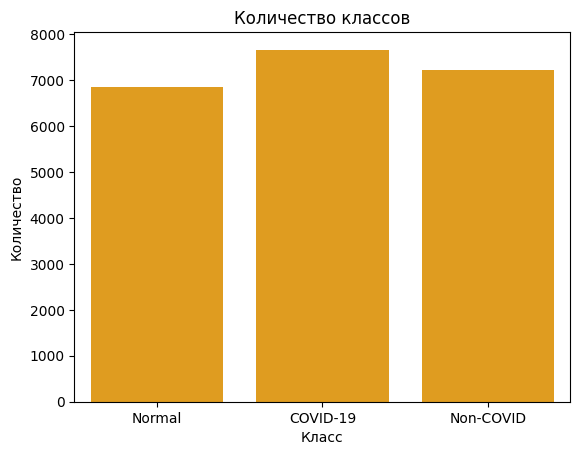

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='label', data=train, color = 'orange')
plt.title('Количество классов')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.show()

In [ ]:
''' Ячейка: Посмотрим на изображения'''

from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import matplotlib.colors as col
import numpy as np
import cv2

def plot_sample(image, lung_mask):
    fig, ax = plt.subplots(1, 3, figsize=(12, 14))
    colors = ['green', 'red']

    cmap1 = col.ListedColormap(colors[0])
    cmap2 = col.ListedColormap(colors[1])

    ax[0].imshow(image, cmap="gray")
    ax[0].set_title("Image", fontsize=12, y=1.01)
    ax[0].axis("off")
    # --------------------------
    ax[1].imshow(lung_mask, cmap="gray")
    ax[1].set_title("Lung Mask", fontsize=12, y=1.01)
    ax[1].axis("off")
    # --------------------------
    ax[2].imshow(image, cmap="gray")
    ax[2].set_title("Image & Mask", fontsize=12, y=1.01)
    ax[2].axis("off")
    # Improved overlay with adjusted alpha
    ax[2].imshow(np.ma.masked_where(lung_mask == False, lung_mask), cmap=cmap1, alpha=0.3)

def process_path(path, color_mode="grayscale"):
    image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE), color_mode=color_mode)
    image = img_to_array(image) / 255.0
    return image



In [ ]:
IMAGE_SIZE = 224
labels=["Lung"]

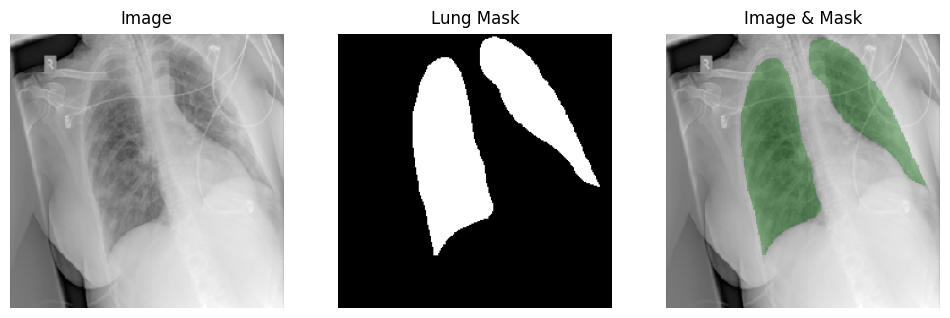

In [ ]:
sample = train[train['label'] == 'COVID-19'].sample(n=1)
sample_image = process_path(sample['image'].item())
sample_lung = process_path(sample['mask'].item())
plot_sample(sample_image,sample_lung)

### 5. Метрики модели, Loss-Function

In [ ]:
try:
  import segmentation_models_pytorch as smp
except ImportError:
  !pip install segmentation_models_pytorch -q
  import segmentation_models_pytorch as smp


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.8 MB/s eta 0:00:00


In [ ]:
JaccardLoss = smp.losses.JaccardLoss(mode='multilabel')
DiceLoss    = smp.losses.DiceLoss(mode='multilabel')
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss  = smp.losses.LovaszLoss(mode='multilabel', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(alpha=0.7, beta=0.3, mode='multilabel', log_loss=False)

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

def criterion(y_pred, y_true):
    return 0.5*BCELoss(y_pred, y_true) + 0.5*TverskyLoss(y_pred, y_true)

In [ ]:
BATCH_SIZE= 32
EPOCHS=5

### 6. Train Model. Вариант с pkbar

In [ ]:
"БАР ТИПА КЕРАС"

try:
  import pkbar
except ImportError:
  !pip install pkbar -q
  import pkbar

In [ ]:
"WARMUP LEARNING RATE"
! pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git -q
from warmup_scheduler import GradualWarmupScheduler

  Preparing metadata (setup.py) ... done


In [ ]:
"ОПРЕДЕЛЕНИЕ МОДЕЛИ ИЗ SEGMENTATION MODELS"

import segmentation_models_pytorch as smp
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau


model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization               # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    in_channels = 1,
    classes=1,                      # model output channels (number of classes in your dataset)
)
LEARNING_RATE = 0.001
LR_FACTOR = 0.5
LR_PATIENCE = 2
EARLY_STOP_PATIENCE = 4
NUM_EPOCHS = EPOCHS


# Define the loss function, optimizer, and learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
reduce_lr_on_plateu = ReduceLROnPlateau(optimizer, mode='min', factor=LR_FACTOR, patience=LR_PATIENCE, verbose=False)
scheduler = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch=5, after_scheduler=reduce_lr_on_plateu)

# Initialize early stopping parameters
early_stop_counter = 0
best_val_loss = float('inf')

In [ ]:
"ТРЕНИРОВКА МОДЕЛИ БЕЗ ИСПОЛЬЗОВАНИЯ DATAPARALLEL И С ИСПОЛЬЗОВАНИЕМ НОРМАЛЬНОГО ПРОГРЕСС БАРА"

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, early_stop_patience):
    best_val_loss = float('inf')
    early_stop_counter = 0

    model.to(DEVICE)  # Перемещаем модель на нужное устройство (на всякий случай)

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0.0
        dice_scores = []
        jaccard_scores = []
        train_losses = []
        val_losses = []
        kbar = pkbar.Kbar(target=len(train_loader), epoch=epoch - 1, num_epochs=num_epochs, width=20, always_stateful=False)

        for batch_index, (images, masks) in enumerate(train_loader):
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Рассчитываем метрики на тренировочном батче
            dice = dice_coef(masks, outputs)
            jaccard = iou_coef(masks, outputs)
            dice_scores.append(dice.item())
            jaccard_scores.append(jaccard.item())

            # Обновляем pkbar с текущими значениями
            kbar.update(batch_index, values=[("loss", loss.item()), ("dice", dice.item()), ("jaccard", jaccard.item())])

        avg_train_loss = train_loss / len(train_loader)
        avg_train_dice = sum(dice_scores) / len(dice_scores)
        avg_train_jaccard = sum(jaccard_scores) / len(jaccard_scores)
        train_losses.append(avg_train_loss)

        # Валидационная фаза
        model.eval()
        val_loss = 0.0
        val_dice_scores = []
        val_jaccard_scores = []
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(DEVICE), masks.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                dice = dice_coef(masks, outputs)
                jaccard = iou_coef(masks, outputs)
                val_dice_scores.append(dice.item())
                val_jaccard_scores.append(jaccard.item())

        avg_val_loss = val_loss / len(val_loader)
        avg_val_dice = sum(val_dice_scores) / len(val_dice_scores)
        avg_val_jaccard = sum(val_jaccard_scores) / len(val_jaccard_scores)
        val_losses.append(avg_val_loss)

        reduce_lr_on_plateu.step(avg_val_loss)

        # Обновляем pkbar на конце каждой эпохи для отображения средних значений валидации
        kbar.add(1, values=[("loss", avg_train_loss), ("dice", avg_train_dice), ("jaccard", avg_train_jaccard),
                            ("val_loss", avg_val_loss), ("val_dice", avg_val_dice), ("val_jaccard", avg_val_jaccard)])

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= early_stop_patience:
            print(f'Early stopping after {early_stop_patience} epochs without improvement.')
            break

    # Загрузка лучшей модели
    model.load_state_dict(torch.load('best_model.pth'))

    return model, train_losses, val_losses

In [ ]:
import multiprocessing as mp
mp.set_start_method('fork', force=True)

In [ ]:
import gc
gc.collect()

0

In [ ]:
trained_model = train_model(model, train_loader, val_loader, DiceLoss, optimizer, reduce_lr_on_plateu, num_epochs=NUM_EPOCHS, early_stop_patience=EARLY_STOP_PATIENCE)

Epoch: 1/5


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


678/679 [==================>.] - ETA: 0s - loss: 0.0576 - dice: 0.9650 - jaccard: 0.9349

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


679/679 [====================] - 317s 467ms/step - loss: 0.0576 - dice: 0.9650 - jaccard: 0.9349 - val_loss: 0.0237 - val_dice: 0.9753 - val_jaccard: 0.9528
Epoch: 2/5
679/679 [====================] - 316s 466ms/step - loss: 0.0242 - dice: 0.9747 - jaccard: 0.9516 - val_loss: 0.0227 - val_dice: 0.9760 - val_jaccard: 0.9540
Epoch: 3/5
679/679 [====================] - 316s 465ms/step - loss: 0.0230 - dice: 0.9759 - jaccard: 0.9537 - val_loss: 0.0228 - val_dice: 0.9759 - val_jaccard: 0.9537
Epoch: 4/5
679/679 [====================] - 316s 465ms/step - loss: 0.0221 - dice: 0.9767 - jaccard: 0.9552 - val_loss: 0.0221 - val_dice: 0.9767 - val_jaccard: 0.9552
Epoch: 5/5
679/679 [====================] - 316s 465ms/step - loss: 0.0213 - dice: 0.9775 - jaccard: 0.9567 - val_loss: 0.0205 - val_dice: 0.9783 - val_jaccard: 0.9582


In [ ]:
# model = torch.load('best_model.pth', map_location=DEVICE)

### 7. EVALUATE

In [ ]:
"ДЕЛАЮ ОЦЕНКУ МОДЕЛИ ПО УКАЗАННЫМ МЕТРИКАМ. ВЕСА МОДЕЛИ ДОЛЖНЫ НАЗЫВАТЬСЯ best_model.pth"

from torch.utils.data import DataLoader
import tqdm  # Импортируем tqdm для отображения progress bar

# Убедитесь, что test_loader настроен с num_workers=0
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    dice_scores = []
    jaccard_scores = []

    with torch.no_grad():
        # Оборачиваем итератор DataLoader в tqdm для отображения прогресса
        progress_bar = tqdm.tqdm(test_loader, total=len(test_loader), desc="Evaluating", leave=True)
        for images, masks in progress_bar:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            masks = masks.float()  # Убедимся, что маски имеют тип float

            outputs = model(images)
            loss = criterion(outputs, masks)
            test_loss += loss.item()

            # Рассчитаем метрики для каждого изображения в батче
            dice = dice_coef(masks, outputs)
            jaccard = iou_coef(masks, outputs)
            dice_scores.append(dice.item())
            jaccard_scores.append(jaccard.item())

            # Обновляем progress bar с текущими значениями потерь
            progress_bar.set_postfix(loss=loss.item(), dice=dice.item(), jaccard=jaccard.item())

    avg_test_loss = test_loss / len(test_loader)
    avg_dice = sum(dice_scores) / len(dice_scores)
    avg_jaccard = sum(jaccard_scores) / len(jaccard_scores)

    print(f"Test Loss: {avg_test_loss:.4f}, Average Dice: {avg_dice:.4f}, Average Jaccard: {avg_jaccard:.4f}")

# Загрузка модели и вызов функции оценки
model.load_state_dict(torch.load('best_model.pth', map_location=DEVICE))
evaluate_model(model, test_loader, criterion)

Evaluating: 100%|██████████| 6788/6788 [01:42<00:00, 66.13it/s, dice=0.983, jaccard=0.967, loss=0.0356]


Test Loss: 0.0790, Average Dice: 0.9779, Average Jaccard: 0.9574


### 8. Функция для вывода результатов

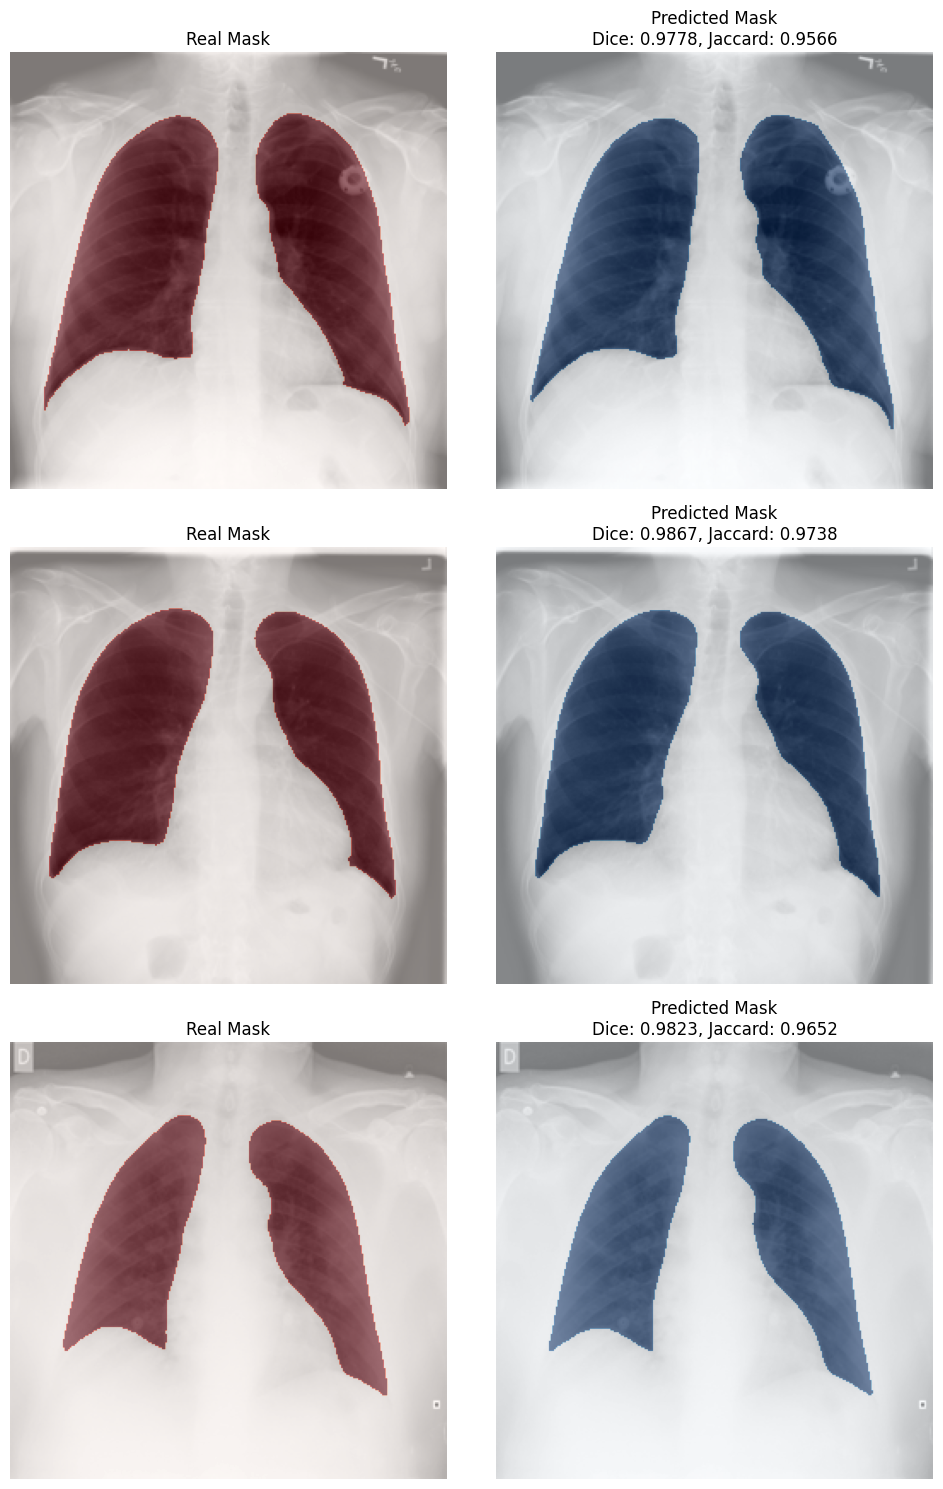

In [ ]:
"ВЫВОЖУ ПРЕДСКАЗАНИЕ МОДЕЛИ, МЕТРИКИ МОДЕЛИ И СРАВНИВАЮ С ОРИГИНАЛОМ"

import matplotlib.pyplot as plt
import numpy as np

def visualize_samples(dataset, model, device, num_samples=3):
    model.eval()
    figure, ax = plt.subplots(nrows=num_samples, ncols=2, figsize=(10, 5 * num_samples))

    for i in range(num_samples):
        # Случайно выбираем семпл из данных
        sample_id = np.random.randint(0, len(dataset))
        images, true_masks = dataset[sample_id]
        images = images.unsqueeze(0).to(device)  # Добавляем размерность батча и перемещаем на устройство
        true_masks = true_masks.unsqueeze(0).to(device)

        with torch.no_grad():
            pred_masks = model(images)
            pred_masks = torch.sigmoid(pred_masks)  # Применяем сигмоиду для получения вероятностей
            pred_masks = (pred_masks > 0.5).float()  # Бинаризуем предсказание

        # Считаем метрики
        dice = dice_coef(true_masks, pred_masks).item()
        jaccard = iou_coef(true_masks, pred_masks).item()

        images = images.cpu().squeeze().numpy()
        true_masks = true_masks.cpu().squeeze().numpy()
        pred_masks = pred_masks.cpu().squeeze().numpy()

        # Визуализация истинного изображения с маской
        ax[i, 0].imshow(images, cmap='gray')
        ax[i, 0].imshow(true_masks, alpha=0.5, cmap='Reds')  # Настоящая маска в красном
        ax[i, 0].title.set_text(f'Real Mask')
        ax[i, 0].axis('off')

        # Визуализация изображения с предсказанной маской
        ax[i, 1].imshow(images, cmap='gray')
        ax[i, 1].imshow(pred_masks, alpha=0.5, cmap='Blues')  # Предсказанная маска в синем
        ax[i, 1].title.set_text(f'Predicted Mask\nDice: {dice:.4f}, Jaccard: {jaccard:.4f}')
        ax[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Пример вызова функции
visualize_samples(test_dataset, model, DEVICE, num_samples=3)

In [ ]:
import torch
from PIL import Image
from torchvision import transforms

def predict_mask(image_path, model, device):
    # Загружаем изображение и преобразуем его в тензор
    image = Image.open(image_path).convert("L")
    image_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)  # Добавляем размерность батча и перемещаем на устройство

    # Предсказание моделью
    model.eval()
    with torch.no_grad():
        pred_mask = model(image_tensor)
        pred_mask = torch.sigmoid(pred_mask)
        pred_mask = (pred_mask > 0.5).float()  # Бинаризация предсказания

    return pred_mask.squeeze().cpu().numpy()  # Возвращаем маску как numpy массив

import matplotlib.pyplot as plt
import numpy as np

def visualize_prediction(image_path, predicted_mask):
    # Загружаем изображение
    image = Image.open(image_path).convert("L")
    image_np = np.array(image)

    # Визуализация
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image_np, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(image_np, cmap='gray')
    plt.imshow(predicted_mask, alpha=0.5, cmap='Blues')  # Наложение предсказанной маски
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()


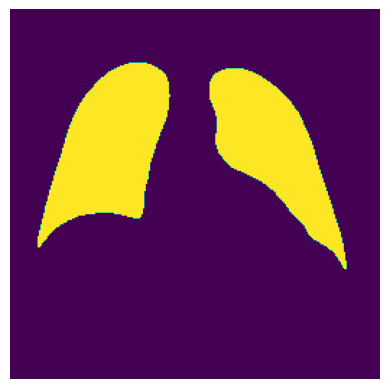

In [ ]:
image_path = '/content/Lung Segmentation Data/Lung Segmentation Data/Test/COVID-19/images/covid_10.png'
predicted_mask = predict_mask(image_path, model, DEVICE)
plt.imshow(predicted_mask)
plt.axis('off')
plt.show()

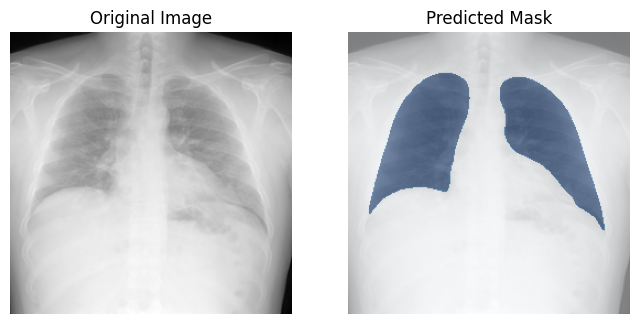

In [ ]:
# Предполагается, что у вас есть модель и device уже определены
image_path = '/content/Lung Segmentation Data/Lung Segmentation Data/Test/COVID-19/images/covid_10.png'
predicted_mask = predict_mask(image_path, model, DEVICE)
visualize_prediction(image_path, predicted_mask)
